In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 
import pycaret
from pycaret.regression import *

# Define the path to the data files
raw_data_path = r'D:\Users\Desktop\insurance\insurance\data\raw\Medical_insurance.csv'
processed_train_path = r'D:\Users\Desktop\insurance\insurance\data\processed\train.csv'
processed_test_path = r'D:\Users\Desktop\insurance\insurance\data\processed\test.csv'


# Load the data
train = pd.read_csv(processed_train_path)
test = pd.read_csv(processed_test_path)
sub = pd.read_csv(raw_data_path)

# Display first 5 rows of training data
train.head()



,age,sex,bmi,children,smoker,region,charges
0,21,male,36.85,0,no,southeast,1534.3045
1,38,female,34.80,2,no,southwest,6571.5440
2,21,female,25.80,0,no,southwest,2007.9450
3,52,female,25.30,2,yes,southeast,24667.4190
4,20,female,26.84,1,yes,southeast,17085.2676


In [3]:
# Round the 'age' column and convert it to integer
train['age'] = train['age'].round().astype(int)
test['age'] = test['age'].round().astype(int)

#  Function to define body category
def group_bmi(x):
    if x >= 0 and x <= 18.5:
        return 'underweight'
    elif x > 18.5 and x <= 25:
        return 'normal'
    elif x > 25 and x <= 30:
        return 'overweight'
    else:
        return 'obese'

# Apply body category function to 'bmi' column
train['body_category'] = train['bmi'].apply(lambda x: group_bmi(x))
test['body_category'] = test['bmi'].apply(lambda x: group_bmi(x))


In [4]:
# function to define the age category
def age_bin(x):
  if x >= 0 and x < 2:
    return "infant"
  elif x >= 2 and x< 5:
    return "toddler"
  elif x >=5 and x < 13:
    return "child"
  elif x >= 13 and x < 20:
    return "teen"
  elif x >= 20 and x < 40 :
    return "adult"
  elif x >= 40 and x < 60:
    return "middle_aged"
  else:
    return "senior"
train['age_group']  = train['age'].apply(lambda x : age_bin(x) )
test['age_group'] = test['age'].apply(lambda x : age_bin(x) )

### data visualization


<Axes: xlabel='age', ylabel='charges'>

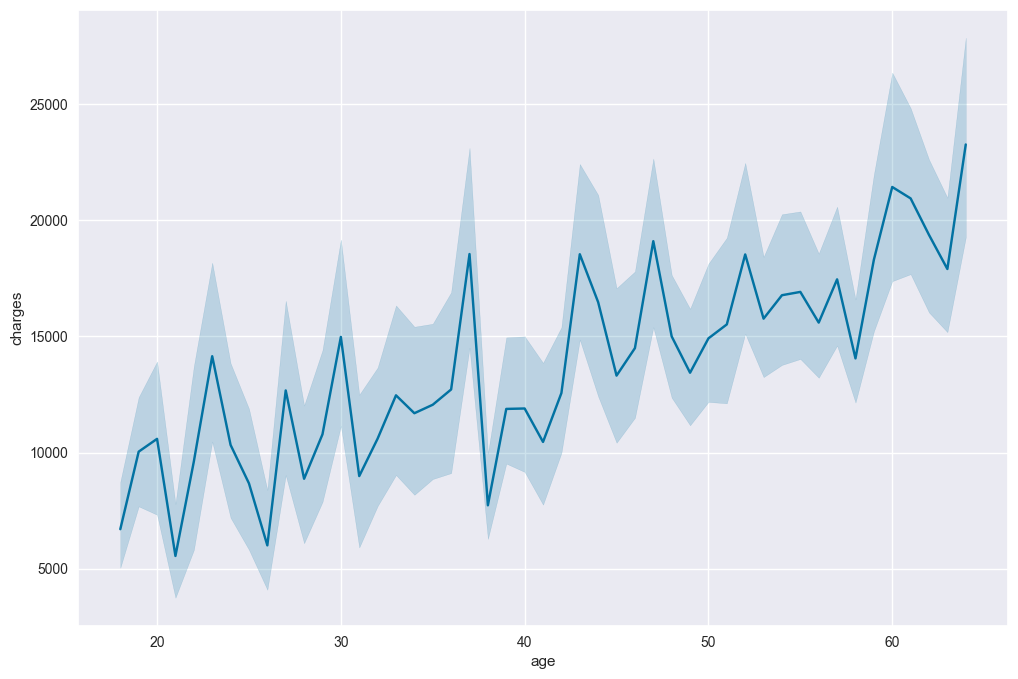

In [5]:


# Set style and plot lineplot
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
sns.lineplot(x='age', y='charges', data=train)


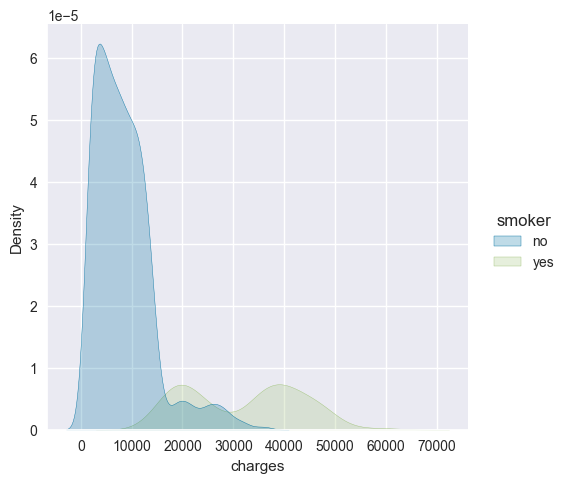

In [6]:
# Displot for 'charges' with hue 'smoker'
sns.displot(train, x='charges', hue='smoker', kind='kde', fill=True)


<Axes: xlabel='age', ylabel='charges'>

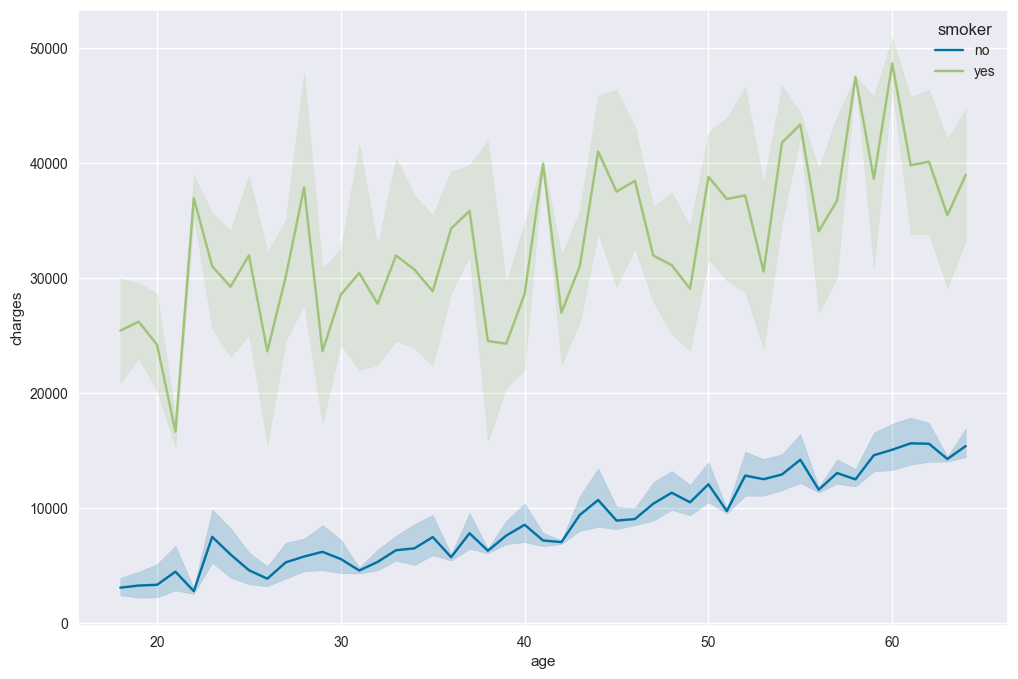

In [7]:
# Set style and plot lineplot with 'smoker' hue
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
sns.lineplot(x='age', y='charges', data=train, hue='smoker')



<Axes: xlabel='body_category', ylabel='count'>

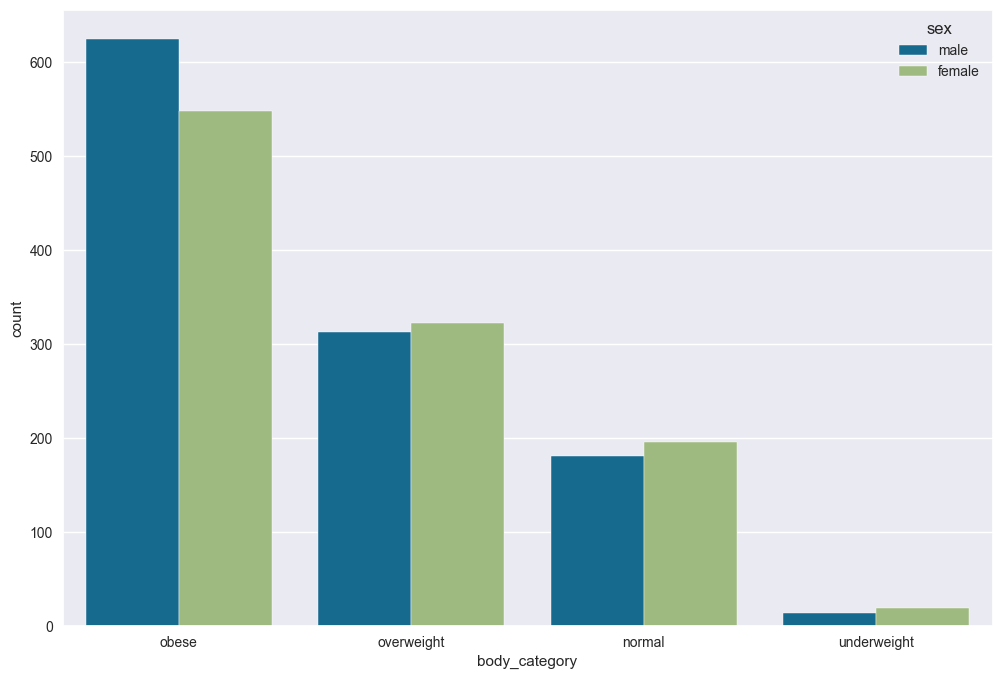

In [8]:
# Countplot for 'body_category' with hue 'sex'
plt.figure(figsize=(12,8))
sns.countplot(x='body_category', data=train, hue='sex')



<Axes: xlabel='age', ylabel='charges'>

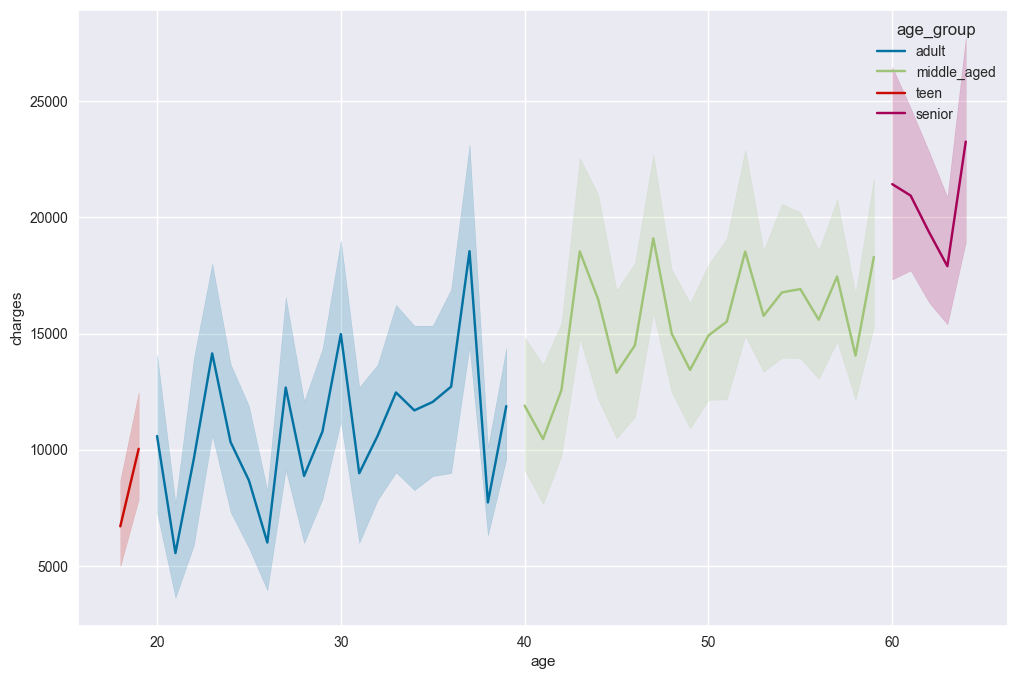

In [9]:
# Set style and plot lineplot with 'age_group' hue
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
sns.lineplot(x='age', y='charges', data=train, hue='age_group')

### model building and inference with pycaret

In [10]:
train.isnull().sum()


age              0
sex              0
bmi              0
children         0
smoker           0
region           0
charges          0
body_category    0
age_group        0
dtype: int64

In [11]:
# import pycaret regression and init setup
from pycaret.regression import *
s = setup(train, target = 'charges', session_id = 123)

,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(2217, 9)"
4,Transformed data shape,"(2217, 18)"
5,Transformed train set shape,"(1551, 18)"
6,Transformed test set shape,"(666, 18)"
7,Numeric features,3
8,Categorical features,5
9,Preprocess,True


In [12]:
best = compare_models(n_select = 15,sort='RMSE')
compare_model_results = pull()

In [13]:
rf = create_model('rf')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:31:00
Status,. . . . . . . . . . . . . . . . . .,Selecting Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1634.3530,11799915.2122,3435.1005,0.9118,0.3418,0.1698
1,2083.7344,18460943.7346,4296.6200,0.8703,0.3633,0.2458
2,1785.9163,16455648.6868,4056.5563,0.8879,0.4018,0.2190
3,1661.3867,10305880.1373,3210.2773,0.9290,0.4088,0.2204
4,1435.9189,10654682.5369,3264.1511,0.9257,0.3075,0.1828
5,1501.8013,9995813.8972,3161.6157,0.9268,0.3068,0.1798
6,1888.6109,14227916.3217,3771.9910,0.9195,0.3269,0.2044
7,1599.4108,14031269.1414,3745.8336,0.8990,0.4016,0.2235
8,1778.0121,15871797.5316,3983.9425,0.8892,0.3789,0.1437


In [14]:
tuned_rf = tune_model(rf,optimize = 'RMSE',search_library = 'optuna')


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1986.7385,15342092.9595,3916.8984,0.8853,0.3537,0.1998
1,2410.1439,21656712.3384,4653.6773,0.8479,0.3703,0.2521
2,2197.3552,17809319.5936,4220.1090,0.8787,0.4251,0.2655
3,1805.8505,10019007.5778,3165.2816,0.9309,0.4129,0.2438
4,1814.6864,13594940.5011,3687.1317,0.9052,0.3463,0.2332
5,1751.5937,11168848.4700,3341.9827,0.9182,0.3046,0.2111
6,2266.0509,17223244.9672,4150.0898,0.9026,0.3566,0.2481
7,1913.9901,16063470.0562,4007.9259,0.8844,0.4219,0.2951
8,2001.0998,17481496.4147,4181.0879,0.8779,0.3838,0.1674


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


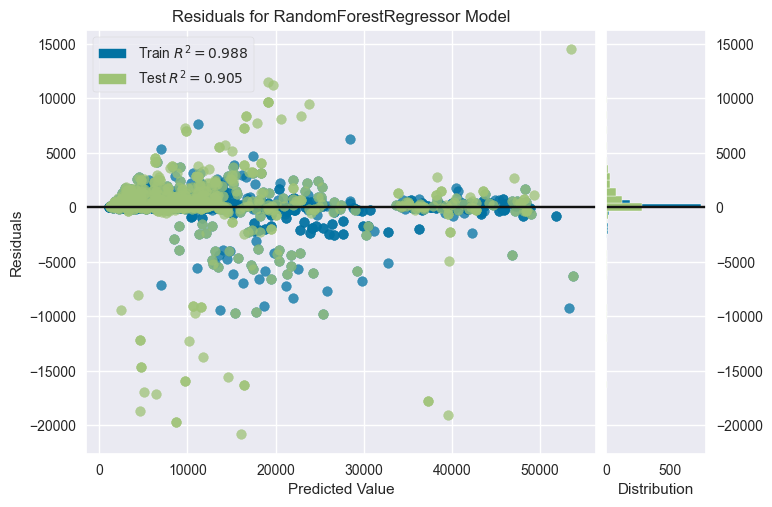

In [15]:
plot_model(tuned_rf)

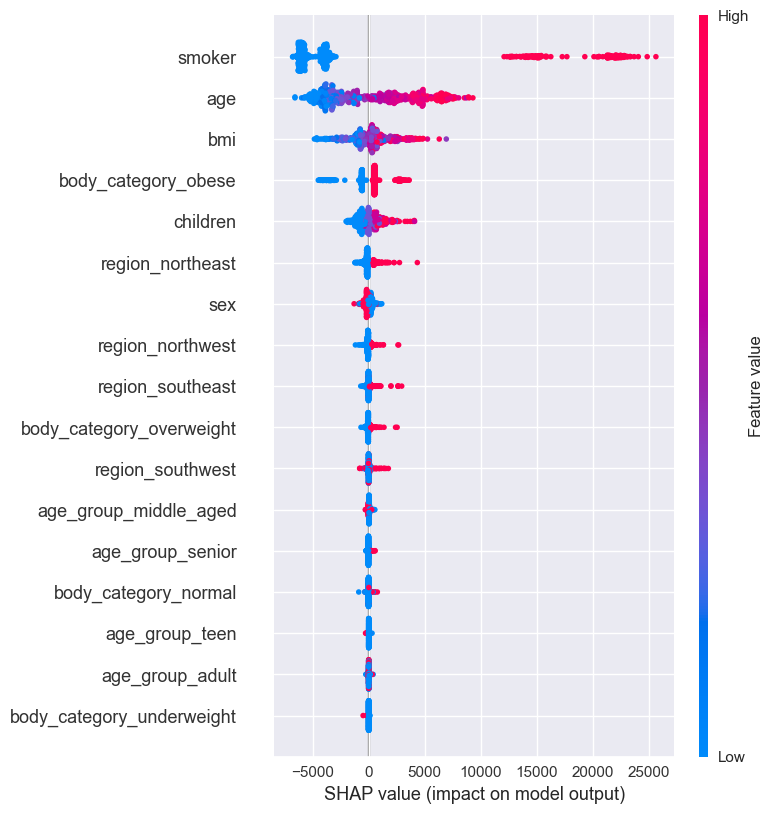

In [16]:
interpret_model(tuned_rf)

In [18]:
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [19]:
val_rf_pred = predict_model(tuned_rf)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1796.2130,14166063.5412,3763.7831,0.9055,0.3272,0.2020


In [20]:
# predictions on new dataset
pred_new_rf = predict_model(tuned_rf, data = test) 
pred_new_rf = pred_new_rf.rename(columns={'Label':'prediction'})
pred_new_rf

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1880.3608,14313285.7565,3783.2903,0.9067,0.3753,0.2548


,age,sex,bmi,children,smoker,region,body_category,age_group,charges,prediction_label
0,49,female,29.924999,0,no,northwest,overweight,middle_aged,8988.159180,9288.706230
1,62,male,26.695000,0,yes,northeast,overweight,senior,28101.333984,28487.855488
2,57,female,20.100000,1,no,southwest,normal,middle_aged,12032.326172,12865.301738
3,22,male,39.500000,0,no,southwest,obese,adult,1682.597046,1880.460809
4,18,female,38.665001,2,no,northeast,obese,teen,3393.356445,5040.247690
...,...,...,...,...,...,...,...,...,...,...
550,26,male,46.529999,1,no,southeast,obese,adult,2927.064697,2972.299583
551,41,male,23.940001,1,no,northeast,normal,middle_aged,6858.479492,7436.507305
552,27,female,31.400000,0,yes,southwest,obese,adult,34838.871094,34704.465664
553,41,female,31.600000,0,no,southwest,obese,middle_aged,6186.126953,6294.167778


 ### Ensemble Model

In [21]:
# train a voting regressor dynamically
blender_specific = blend_models(estimator_list = compare_models(n_select = 5))

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1220.7380,12795565.8976,3550.5935,0.9106,0.3343,0.1411,0.2800
rf,Random Forest Regressor,1694.5891,13256063.0135,3620.5838,0.9076,0.3525,0.1979,0.5130
catboost,CatBoost Regressor,1835.2124,13503764.3489,3649.3020,0.9056,0.3661,0.2186,0.6300
lightgbm,Light Gradient Boosting Machine,2135.0628,15601946.9106,3936.3172,0.8908,0.4007,0.2555,0.1640
gbr,Gradient Boosting Regressor,2096.8990,16470314.8509,4033.2209,0.8850,0.3666,0.2446,0.1740
dt,Decision Tree Regressor,1529.0384,23370213.2224,4810.6243,0.8358,0.3804,0.1789,0.1320
ada,AdaBoost Regressor,4129.8755,26393803.6613,5127.1024,0.8154,0.6197,0.7172,0.1280
ridge,Ridge Regression,4218.6527,34661629.6561,5872.2625,0.7577,0.6006,0.4467,0.1280
llar,Lasso Least Angle Regression,4216.3158,34664454.5547,5872.3220,0.7576,0.6055,0.4466,0.0510
br,Bayesian Ridge,4218.6454,34663575.4435,5872.3927,0.7576,0.6014,0.4468,0.0830


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1684.3822,12157334.7092,3486.7370,0.9091,0.3103,0.1598
1,2045.7846,16859891.1574,4106.0798,0.8816,0.3355,0.2313
2,1865.3754,15788485.6147,3973.4727,0.8925,0.4033,0.2343
3,1550.3111,8382479.7286,2895.2512,0.9422,0.3713,0.1974
4,1516.8569,10278753.2876,3206.0495,0.9283,0.2889,0.1897
5,1559.9862,10063046.6561,3172.2305,0.9263,0.2919,0.1883
6,1829.5621,12964347.5510,3600.6038,0.9267,0.3230,0.2000
7,1697.4517,13825468.4535,3718.2615,0.9005,0.4116,0.2580
8,1806.7285,15581155.2795,3947.2972,0.8912,0.3681,0.1562


In [22]:
blender_specific

VotingRegressor(estimators=[('Extra Trees Regressor',
                             ExtraTreesRegressor(n_jobs=-1, random_state=123)),
                            ('Random Forest Regressor',
                             RandomForestRegressor(n_jobs=-1,
                                                   random_state=123)),
                            ('CatBoost Regressor',
                             <catboost.core.CatBoostRegressor object at 0x0000020EFCFBEA50>),
                            ('Light Gradient Boosting Machine',
                             LGBMRegressor(n_jobs=-1, random_state=123)),
                            ('Gradient Boosting Regressor',
                             GradientBoostingRegressor(random_state=123))],
                n_jobs=-1)

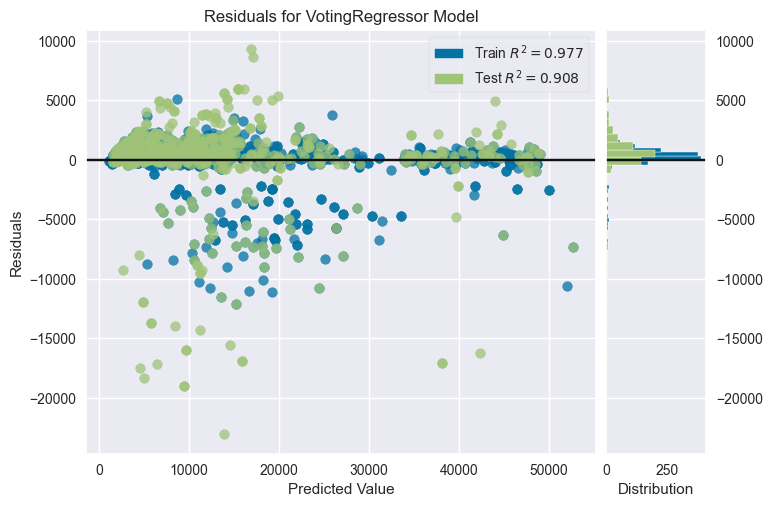

In [23]:
plot_model(blender_specific)

In [24]:
evaluate_model(blender_specific)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [25]:
val_pred = predict_model(blender_specific)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,1883.4587,13820322.8709,3717.5695,0.9078,0.3260,0.2153


### Predictions on unseen data


In [26]:
# predictions on new dataset
pred_new = predict_model(blender_specific, data = test) #new_data is pd dataframe
pred_new = pred_new.rename(columns={'Label':'prediction'})
pred_new

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,1914.4301,13812580.3366,3716.5280,0.9100,0.3660,0.2561


,age,sex,bmi,children,smoker,region,body_category,age_group,charges,prediction_label
0,49,female,29.924999,0,no,northwest,overweight,middle_aged,8988.159180,9240.931601
1,62,male,26.695000,0,yes,northeast,overweight,senior,28101.333984,28292.316936
2,57,female,20.100000,1,no,southwest,normal,middle_aged,12032.326172,11956.010551
3,22,male,39.500000,0,no,southwest,obese,adult,1682.597046,2306.122304
4,18,female,38.665001,2,no,northeast,obese,teen,3393.356445,7871.500677
...,...,...,...,...,...,...,...,...,...,...
550,26,male,46.529999,1,no,southeast,obese,adult,2927.064697,3490.419737
551,41,male,23.940001,1,no,northeast,normal,middle_aged,6858.479492,8025.932677
552,27,female,31.400000,0,yes,southwest,obese,adult,34838.871094,34757.161714
553,41,female,31.600000,0,no,southwest,obese,middle_aged,6186.126953,6124.027354


In [ ]:

from pycaret.regression import save_model, load_model

save_path = r'D:\Users\Desktop\insurance\insurance\notebooks\blender_specific_saved_06142021'


save_model(blender_specific, save_path)

blend_saved = load_model(save_path)

# Making predictions
pred = blend_saved.predict(test)
print(pred[:5])  


In [27]:
save_model(blender_specific ,r'D:\Users\Desktop\insurance\insurance\notebooks\blender_specific_saved_06142021')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['age', 'bmi', 'children'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['sex', 'smoker', 'region',
                                              'body_category', 'age_group'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_encoding',
                  TransformerWrapper(inclu...
                                               ExtraTreesRegressor(n_jobs=-1,
                                                                   random_state=123)),
                                              ('Random Forest Regressor',
                                               RandomForestRegressor(n_jobs=-1,
                                                                     random_state=123)),
     

In [34]:

blend_saved = load_model(r'D:\Users\Desktop\insurance\insurance\notebooks\blender_specific_saved_06142021')

# Drop the target column 'charges' from test dataset
if 'charges' in test.columns:
    test = test.drop(columns=['charges'])

pred = blend_saved.predict(test)
print(pred[:5])  

Transformation Pipeline and Model Successfully Loaded
[ 9240.93160139 28292.31693644 11956.01055061  2306.12230406
  7871.50067701]


In [35]:
import gradio as gr

In [36]:
#preprocess
def encode_attributes(df): 
    df['body_category'] = df['bmi'].apply(lambda x: group_bmi(x)) 
    df['age_group'] = df['age'].apply(lambda x: age_bin(x)) 
    return df

In [37]:
def predict_charges(age, bmi, sex, smoker, region, children):
    df = pd.DataFrame.from_dict({'sex': [sex], 'age': [age], 'smoker': [smoker], 'bmi': [bmi], 'region': [region], 'children': [children]})
    df = encode_attributes(df)  
    pred = blend_saved.predict(df).tolist()[0]
    return 'charges : ' + str(pred) + " in rupees"


In [43]:
import gradio as gr

#  inputs
sex = gr.Radio(['female', 'male'], label="sex")
smoker = gr.Radio(['no', 'yes'], label="smoker")
children = gr.Radio([2, 3, 1, 4, 5, 0], label="children")
region = gr.Radio(['northeast', 'southeast', 'northwest', 'southwest'], label="region")
age = gr.Slider(minimum=15, maximum=75, value=16, label="age")  # Use 'value' instead of 'default'
bmi = gr.Slider(minimum=15, maximum=60, value=16, label="bmi")  # Use 'value' instead of 'default'

#  function to predict charges
def predict_charges(sex, smoker, children, region, age, bmi):
    return f"Predicted Charges: {age * 1000 + bmi * 200}"


interface = gr.Interface(fn=predict_charges,
                         inputs=[sex, smoker, children, region, age, bmi],
                         outputs="text")


interface.launch()




* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Created dataset file at: .gradio\flagged\dataset1.csv
